## Setup and Data Loading

In [133]:
import os
import random
from shutil import copy2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL 
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm 
import pandas as pd
from collections import Counter

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [6]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

torch version :  2.5.1+cu124
torchvision version :  0.20.1+cu124
numpy version :  1.26.4
matplotlib version :  3.9.2


## Exploring the dataset

In [8]:
! ls -l ../data

total 16
-rw-r--r-- 1 root root 1436 Jan 24 18:32 README.md
drwxr-xr-x 6 root root 4096 Jan 24 17:58 Testing
drwxr-xr-x 6 root root 4096 Jan 24 17:54 Training
-rw-r--r-- 1 root root 2090 Jan 24 18:20 data.ipynb


In [17]:
train_dir = os.path.join("..","data", "Training")

In [19]:
# check the diffenent classes of the dataset
classes = os.listdir(train_dir)
classes

['pituitary', 'meningioma', 'notumor', 'glioma']

In [20]:
def sample_images(data_path, classname):
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

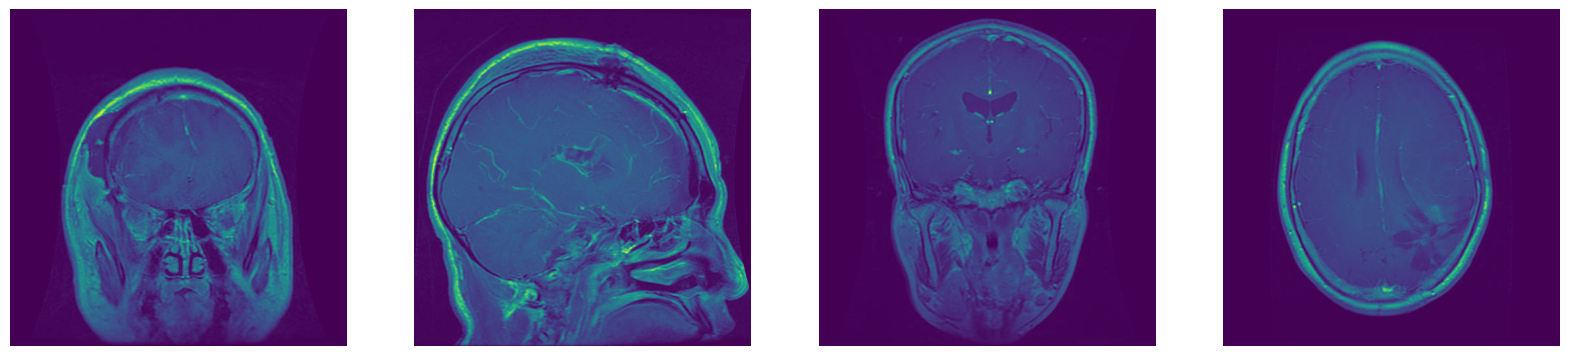

In [30]:
sample_images(train_dir, "glioma")

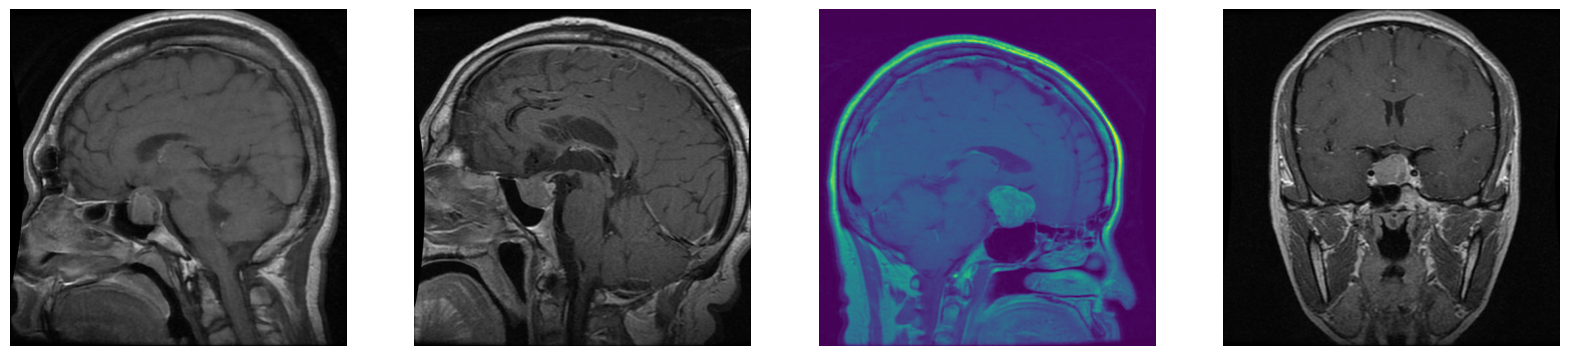

In [31]:
sample_images(train_dir, "pituitary")

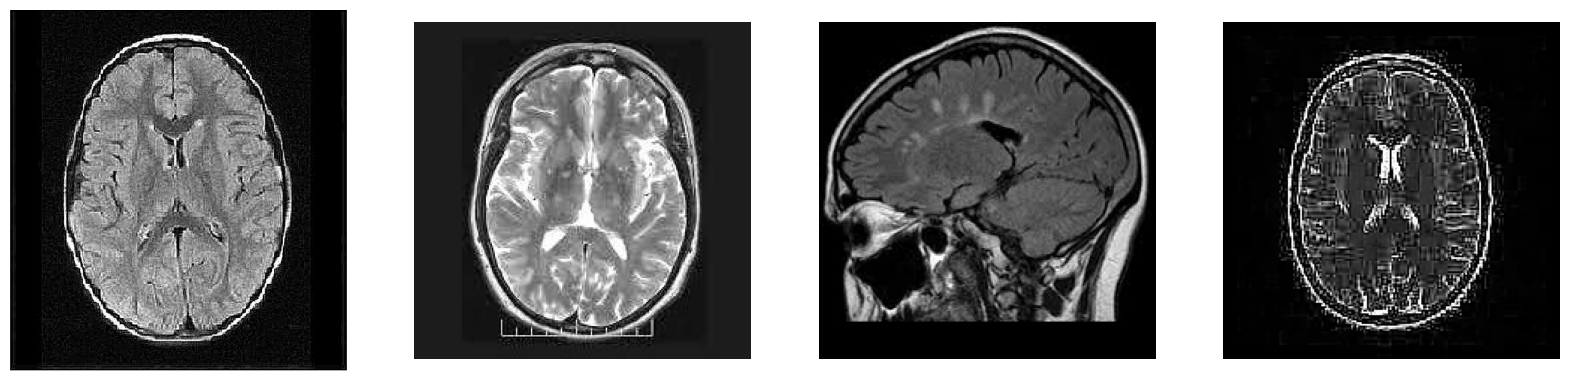

In [32]:
sample_images(train_dir, "notumor")

#### View the the number of image in each directory 

In [56]:
glioma_dir = os.path.join(train_dir,"glioma")
print(f"Number of glioma image: {len(os.listdir(glioma_dir))}")

Number of glioma image: 1321


In [57]:
meningioma_dir = os.path.join(train_dir,"meningioma")
print(f"Number of glioma image: {len(os.listdir(meningioma_dir))}")

Number of glioma image: 1339


In [58]:
notumor_dir = os.path.join(train_dir,"notumor")
print(f"Number of glioma image: {len(os.listdir(notumor_dir))}")

Number of glioma image: 1595


In [59]:
pituitary_dir = os.path.join(train_dir,"notumor")
print(f"Number of glioma image: {len(os.listdir(pituitary_dir))}")

Number of glioma image: 1595


#### Check the shape and number of channel in the image dataset

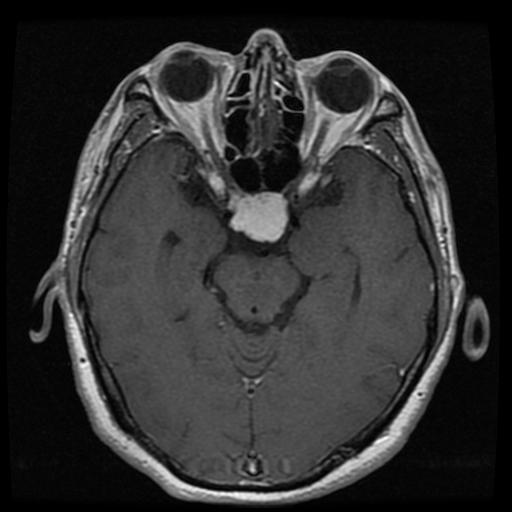

In [65]:
meningioma_sample = os.listdir(meningioma_dir)[0]
meningioma_sample_img = PIL.Image.open(os.path.join(meningioma_dir, meningioma_sample))
meningioma_sample_img

In [67]:
meningioma_sample_img.mode, meningioma_sample_img.size

('L', (512, 512))

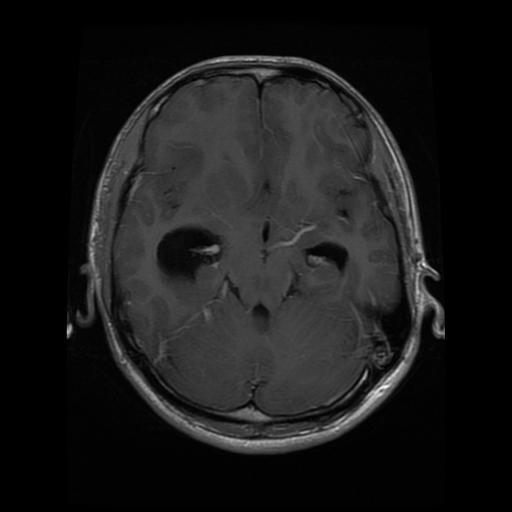

In [83]:
glioma_sample = os.listdir(glioma_dir)[1050]
glioma_sample_img = PIL.Image.open(os.path.join(glioma_dir, glioma_sample))
glioma_sample_img

In [85]:
glioma_sample_img.mode, glioma_sample_img.size

('L', (512, 512))

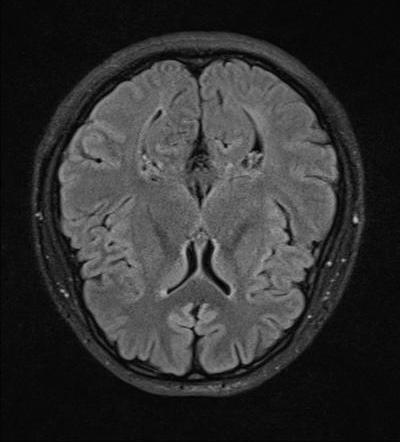

In [86]:
notumor_sample = os.listdir(notumor_dir)[1050]
notumor_sample_img = PIL.Image.open(os.path.join(notumor_dir, notumor_sample))
notumor_sample_img

In [87]:
notumor_sample_img.mode, notumor_sample_img.size

('RGB', (400, 442))

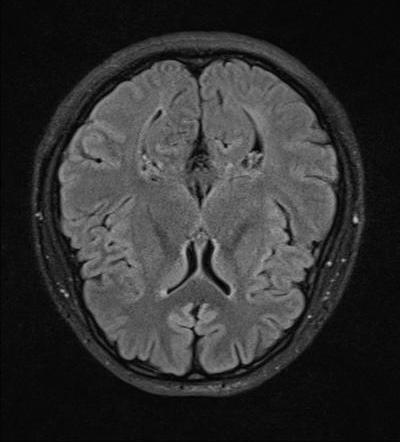

In [88]:
pituitary_sample = os.listdir(pituitary_dir)[1050]
pituitary_sample_img = PIL.Image.open(os.path.join(pituitary_dir, pituitary_sample))
pituitary_sample_img

In [89]:
pituitary_sample_img.mode, pituitary_sample_img.size

('RGB', (400, 442))

#### The dataset does not have the same size and mode we have to convert them to the same channel and also to the same size

In [93]:
class ConvertImage:
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert("RGB")
        return img    

### Normalize the dataset

In [119]:
transform_nonorm = transforms.Compose(
    [
        ConvertImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

batch_size=32

In [122]:
dataset = datasets.ImageFolder(train_dir, transform=transform_nonorm)
loader = DataLoader(dataset, batch_size=batch_size)

In [121]:
def mean_std(loader):
    count, count_square, num_batches = 0,0, 0
    for data, _ in tqdm(loader):
        count += torch.mean(data, dim=[0, 2, 3])
        count_square += torch.mean(data ** 2, dim=[0,2,3])
        num_batches += 1
        
    mean = count / num_batches
    std = (count_square / num_batches - mean**2) ** 0.5
    
    return mean, std

In [124]:
mean, std = mean_std(loader)

100%|██████████| 179/179 [00:38<00:00,  4.64it/s]


In [125]:
mean, std

(tensor([0.1855, 0.1856, 0.1856]), tensor([0.2003, 0.2003, 0.2003]))

We have not normalized the data so the mean is not 0 ans std is not one

In [126]:
transform = transforms.Compose(
    [
        ConvertImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [127]:
batch_size = 32
dataset = datasets.ImageFolder(train_dir, transform=transform)
dataset_loader = DataLoader(dataset, batch_size=batch_size)

In [128]:
norm_mean, norm_std = mean_std(dataset_loader)

100%|██████████| 179/179 [00:30<00:00,  5.91it/s]


In [129]:
norm_mean, norm_std

(tensor([ 2.6722e-08, -2.7471e-09,  6.0021e-08]),
 tensor([1.0000, 1.0000, 1.0000]))

we now have the normalized mean and std

### Divide the dataset into training and vaidation dataset

In [130]:
train_dataset, val_dataset = random_split(dataset_loader, [0.8, 0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(dataset_loader)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.45% of full data
Validation data is 19.55% of full data


In [135]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})